In [100]:
# Standard DS imports
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns
from tqdm import tqdm


# All pytorch dependencies
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split



# all tensorflow dependencies
import tensorflow as tf
import keras
from keras.src.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras import metrics

In [101]:
#Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

                     duration_ms  explicit  danceability    energy       key  \
duration_ms             1.000000 -0.065263     -0.073426  0.058523  0.008114   
explicit               -0.065263  1.000000      0.122507  0.096955  0.004484   
danceability           -0.073426  0.122507      1.000000  0.134325  0.036469   
energy                  0.058523  0.096955      0.134325  1.000000  0.048006   
key                     0.008114  0.004484      0.036469  0.048006  1.000000   
loudness               -0.003470  0.108588      0.259077  0.761690  0.038590   
mode                   -0.035556 -0.037212     -0.069219 -0.078362 -0.135916   
speechiness            -0.062600  0.307952      0.108626  0.142509  0.020418   
acousticness           -0.103788 -0.094403     -0.171533 -0.733906 -0.040937   
instrumentalness        0.124371 -0.103404     -0.185606 -0.181879 -0.006823   
liveness                0.010321  0.032549     -0.131617  0.184796 -0.001600   
valence                -0.154479 -0.0033

<Axes: >

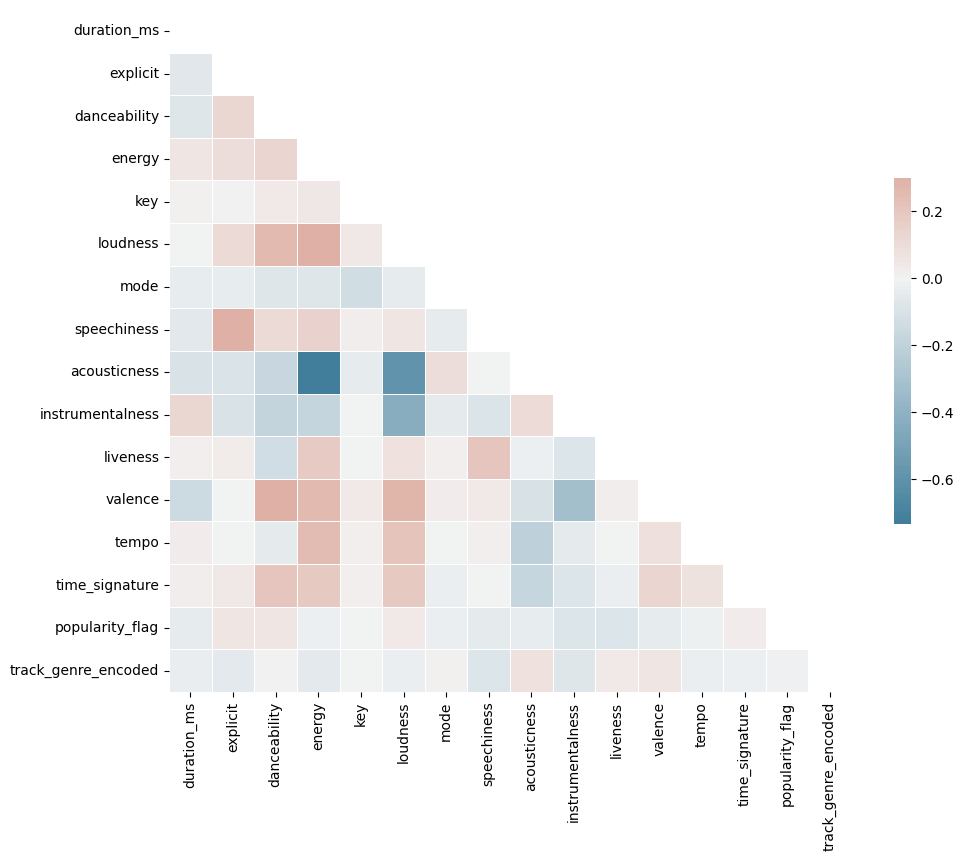

In [102]:
# Calculate correlation matrix
corr_matrix = dataFrame.corr()

# Show correlation matrix
print(corr_matrix)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True,)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Label to integer mapping: {'acoustic': 0, 'afrobeat': 1, 'alt-rock': 2, 'alternative': 3, 'ambient': 4, 'anime': 5, 'black-metal': 6, 'bluegrass': 7, 'blues': 8, 'brazil': 9, 'breakbeat': 10, 'british': 11, 'cantopop': 12, 'chicago-house': 13, 'children': 14, 'chill': 15, 'classical': 16, 'club': 17, 'comedy': 18, 'country': 19, 'dance': 20, 'dancehall': 21, 'death-metal': 22, 'deep-house': 23, 'detroit-techno': 24, 'disco': 25, 'disney': 26, 'drum-and-bass': 27, 'dub': 28, 'dubstep': 29, 'edm': 30, 'electro': 31, 'electronic': 32, 'emo': 33, 'folk': 34, 'forro': 35, 'french': 36, 'funk': 37, 'garage': 38, 'german': 39, 'gospel': 40, 'goth': 41, 'grindcore': 42, 'groove': 43, 'grunge': 44, 'guitar': 45, 'happy': 46, 'hard-rock': 47, 'hardcore': 48, 'hardstyle': 49, 'heavy-metal': 50, 'hip-hop': 51, 'honky-tonk': 52, 'house': 53, 'idm': 54, 'indian': 55, 'indie': 56, 'indie-pop': 57, 'industrial': 58, 'iranian': 59, 'j-dance': 60, 'j-idol': 61, 'j-pop': 62, 'j-rock': 63, 'jazz': 64, 'k-pop': 65, 'kids': 66, 'latin': 67, 'latino': 68, 'malay': 69, 'mandopop': 70, 'metal': 71, 'metalcore': 72, 'minimal-techno': 73, 'mpb': 74, 'new-age': 75, 'opera': 76, 'pagode': 77, 'party': 78, 'piano': 79, 'pop': 80, 'pop-film': 81, 'power-pop': 82, 'progressive-house': 83, 'psych-rock': 84, 'punk': 85, 'punk-rock': 86, 'r-n-b': 87, 'reggae': 88, 'reggaeton': 89, 'rock': 90, 'rock-n-roll': 91, 'rockabilly': 92, 'romance': 93, 'sad': 94, 'salsa': 95, 'samba': 96, 'sertanejo': 97, 'show-tunes': 98, 'singer-songwriter': 99, 'ska': 100, 'sleep': 101, 'songwriter': 102, 'soul': 103, 'spanish': 104, 'study': 105, 'swedish': 106, 'synth-pop': 107, 'tango': 108, 'techno': 109, 'trance': 110, 'trip-hop': 111, 'turkish': 112, 'world-music': 113}

This is a lot to go through but basically it is assigning each genre a number so that I now have a quantitative variable instead of a qualitative one. this allows for a neural net to run on the data.

In [103]:
inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

In [104]:
xtrain, xtest, ytrain, ytest = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

In [105]:
# Assuming y_train is your training labels
positive_class_proportion = np.mean(ytrain)

print(f"The AUPRC baseline is: {positive_class_proportion}")

The AUPRC baseline is: 0.24455043859649123


This means that if my model is guessing it should have a score of 0.24 or 24% as the I am working with an unbalanced dataset. It focuses on the trade-off between precision and recall, and the AUPRC (Area Under the Precision-Recall Curve) is  useful for evaluating imbalanced dataset models... like what I have. It provides a measure of how well the model can increase its prediction accuracy on the positive class without incurring too many false positive errors.

In [106]:
model = neighbors.KNeighborsRegressor(2)
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)
ypred = (ypred > 0.5).astype(int)  # Apply a threshold 

y_train_scores = model.predict(xtrain)
y_test_scores = model.predict(xtest)

#Apply same threshold to train predictions
y_train_pred = (y_train_scores > 0.5).astype(int)
y_test_pred = (y_test_scores > 0.5).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

AUPRC on Training set: 0.8026849338340913
AUPRC on Testing set: 0.48990156981784766
F1 Score on Training set: 0.6470374188853175
F1 Score on Testing set: 0.32590855803048063


this does fine on the training set but leaves much to be desired on the testing set. for this project any f1 score over .5 will be a good model

In [107]:
model = neighbors.KNeighborsClassifier(n_neighbors=2)
model.fit(xtrain, ytrain.values.ravel())
y_train_scores = model.predict_proba(xtrain)[:, 1]
y_test_scores = model.predict_proba(xtest)[:, 1]

#Apply same threshold to train predictions
y_train_pred = (y_train_scores > 0.5).astype(int)
y_test_pred = (y_test_scores > 0.5).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

AUPRC on Training set: 0.8026849338340913
AUPRC on Testing set: 0.48990156981784766
F1 Score on Training set: 0.6470374188853175
F1 Score on Testing set: 0.32590855803048063


In [108]:
# Data importing
dataFrame = pd.read_csv('./dataset.csv')
dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

# Split into features and target
X = dataFrame.drop(columns=['popularity_flag'])
y = dataFrame['popularity_flag']

In [117]:
# Handle missing values - filling with 0 as an example
X_filled = X.fillna(0)

# Optionally, convert to a specific dtype (e.g., float32) to ensure consistency
X_filled = X_filled.astype('float32')

# Now convert to PyTorch tensors
X_tensor = torch.tensor(X_filled.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Assuming y is already numeric and has no missing values

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Use pin_memory=True safely because data is on CPU
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, pin_memory=True)

In [118]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [119]:
# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ELU(),
            nn.Linear(4, 4),
            nn.ELU(),
            nn.Linear(4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [120]:
# Loss Functions
def calculate_f1(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_y, pred_y = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.round(torch.sigmoid(logits))
            true_y.extend(y.view(-1).tolist())
            pred_y.extend(preds.view(-1).tolist())
    f1 = f1_score(true_y, pred_y)
    return f1

# Move the model to the specified device (GPU or CPU)
model = NeuralNetwork(X_tensor.shape[1]).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters())


# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



# Initialize the model and optimizer
input_shape = X_tensor.shape[1]
model = NeuralNetwork(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters())

# Example of how to train with class weights for a single epoch
class_weights = torch.tensor([3.6]).to(device)  # Example class weights
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Assuming you have a train_loader and a validation_loader

class_weights_grid = torch.linspace(1, 10, 10).to(device)  # PyTorch tensor for class weights

best_f1 = 0
best_pos_weight = None

for weight in tqdm(class_weights_grid):
    pos_weight = torch.tensor([weight]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Initialize model and optimizer for each run
    model = NeuralNetwork(input_shape).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    # Train the model
    train_loop(train_loader, model, loss_fn, optimizer)

    # Evaluate F1 Score on validation set
    f1 = calculate_f1(model, test_loader, device)

    if f1 > best_f1:
        best_f1 = f1
        best_pos_weight = weight

print("Best class weight (pos_weight): ", best_pos_weight.item())
print("Best F1 score: ", best_f1)


  0%|          | 0/10 [00:00<?, ?it/s]

loss: 0.843602  [    0/91200]
loss: 0.775957  [20000/91200]
loss: 0.763646  [40000/91200]
loss: 0.736082  [60000/91200]
loss: 0.716721  [80000/91200]


 10%|█         | 1/10 [00:02<00:19,  2.18s/it]

loss: 0.880297  [    0/91200]
loss: 0.856037  [20000/91200]
loss: 0.876831  [40000/91200]
loss: 0.866434  [60000/91200]
loss: 0.835242  [80000/91200]


 20%|██        | 2/10 [00:04<00:17,  2.14s/it]

loss: 1.219893  [    0/91200]
loss: 1.103075  [20000/91200]
loss: 1.046402  [40000/91200]
loss: 1.010805  [60000/91200]
loss: 1.061100  [80000/91200]


 30%|███       | 3/10 [00:06<00:14,  2.13s/it]

loss: 1.223405  [    0/91200]
loss: 1.223405  [20000/91200]
loss: 1.285788  [40000/91200]
loss: 1.213008  [60000/91200]
loss: 1.264994  [80000/91200]


 40%|████      | 4/10 [00:08<00:13,  2.25s/it]

loss: 1.375258  [    0/91200]
loss: 1.380319  [20000/91200]
loss: 1.360075  [40000/91200]
loss: 1.392972  [60000/91200]
loss: 1.372431  [80000/91200]


 50%|█████     | 5/10 [00:11<00:11,  2.26s/it]

loss: 1.438280  [    0/91200]
loss: 1.403623  [20000/91200]
loss: 1.576910  [40000/91200]
loss: 1.611567  [60000/91200]
loss: 1.524924  [80000/91200]


 60%|██████    | 6/10 [00:13<00:08,  2.24s/it]

loss: 1.401754  [    0/91200]
loss: 1.577429  [20000/91200]
loss: 1.661892  [40000/91200]
loss: 1.527799  [60000/91200]
loss: 1.550348  [80000/91200]


 70%|███████   | 7/10 [00:15<00:06,  2.23s/it]

loss: 1.629362  [    0/91200]
loss: 1.671111  [20000/91200]
loss: 1.581649  [40000/91200]
loss: 1.641291  [60000/91200]
loss: 1.611470  [80000/91200]


 80%|████████  | 8/10 [00:17<00:04,  2.20s/it]

loss: 1.689785  [    0/91200]
loss: 1.637072  [20000/91200]
loss: 1.659663  [40000/91200]
loss: 1.689785  [60000/91200]
loss: 1.704846  [80000/91200]


 90%|█████████ | 9/10 [00:19<00:02,  2.19s/it]

loss: 2.252728  [    0/91200]
loss: 2.252728  [20000/91200]
loss: 2.658220  [40000/91200]
loss: 2.252728  [60000/91200]
loss: 2.221537  [80000/91200]


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]

Best class weight (pos_weight):  1.0
Best F1 score:  0.39022840399618736


All code below is from tensorflow, however, as I couldn't gpu accelerate it I am switching to pytorch since that will allow me to use the GPU

In [113]:

# Convert to tensor
X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y.values, dtype=tf.float32)

# Calculate the index at which to split the dataset
train_size = int(0.8 * len(X))

# Manually slice the tensors for train/test sets
x_train_tensor = X_tensor[:train_size]
y_train_tensor = y_tensor[:train_size]
x_test_tensor = X_tensor[train_size:]
y_test_tensor = y_tensor[train_size:]


In [114]:
@keras.saving.register_keras_serializable()
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@keras.saving.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_true,y_pred))

@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred,):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

@keras.saving.register_keras_serializable()
def r_squared_loss(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return 1 - r2  # or you can return -r2 to minimize the negative value

def custom_loss(y_true, y_pred):
    # Assign costs
    cost_fp = 2.0  # cost of a false positive
    cost_fn = 5.0  # cost of a false negative

    # Calculate binary cross-entropy
    bce = tf.keras.losses.BinaryCrossentropy()
    base_loss = bce(y_true, y_pred)

    # Calculate false positives and false negatives
    y_pred_binary = tf.round(y_pred)
    fp = tf.math.reduce_sum(tf.math.multiply(tf.math.subtract(y_pred_binary, y_true), cost_fp))
    fn = tf.math.reduce_sum(tf.math.multiply(tf.math.subtract(y_true, y_pred_binary), cost_fn))

    # Add to base loss
    return base_loss + fp + fn

def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

In [115]:
input_shape = (x_train_tensor.shape[1],)

# Build model function
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [116]:

# Define a set of class weights to evaluate
class_weights_grid = [{0:1.0, 1:weight} for weight in np.linspace(1, 10, 10)]  # Drop the 100 down to 10 if you are running this on a weaker computer.

# Initial placeholders for the best weights and highest f1 score
best_class_weights = None
highest_f1 = 0

for class_weights in tqdm(class_weights_grid):

    #Build and compile model as before
    model = build_model(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall'),
                           metrics.AUC(name='auc')])

    # Train model with current class weight
    model.fit(x_train_tensor,
              y_train_tensor,
              epochs=20,
              validation_split=0.1,
              batch_size=200,
              class_weight=class_weights,
              verbose=0) # Turn off output 

    # Evaluate F1 Score
    y_train_scores = model.predict(x_train_tensor).flatten()
    y_train_pred = (y_train_scores > 0.5).astype(int)
    f1 = f1_score(y_train_tensor, y_train_pred)

    if f1 > highest_f1:
        best_class_weights = class_weights
        highest_f1 = f1

# Output the best class weights
print("Best class weights: ", best_class_weights)
print("Best F1 score: ", highest_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

2850/2850 [==============================] - 2s 698us/step


 10%|█         | 1/10 [00:13<02:00, 13.40s/it]

2850/2850 [==============================] - 2s 699us/step


 20%|██        | 2/10 [00:26<01:46, 13.30s/it]

2850/2850 [==============================] - 2s 700us/step


 30%|███       | 3/10 [00:39<01:32, 13.18s/it]

2850/2850 [==============================] - 2s 711us/step


 40%|████      | 4/10 [00:53<01:19, 13.25s/it]

2850/2850 [==============================] - 2s 684us/step


 50%|█████     | 5/10 [01:06<01:06, 13.27s/it]

2850/2850 [==============================] - 2s 689us/step


 60%|██████    | 6/10 [01:19<00:52, 13.21s/it]

2850/2850 [==============================] - 2s 680us/step


 70%|███████   | 7/10 [01:32<00:39, 13.16s/it]

2850/2850 [==============================] - 2s 693us/step


 80%|████████  | 8/10 [01:45<00:26, 13.23s/it]

2850/2850 [==============================] - 2s 688us/step


 90%|█████████ | 9/10 [01:58<00:13, 13.19s/it]

2850/2850 [==============================] - 2s 689us/step


100%|██████████| 10/10 [02:11<00:00, 13.20s/it]

Best class weights:  {0: 1.0, 1: 4.0}
Best F1 score:  0.4070700367979731


Now that I have found the best class weight I will use that to train the final model

In [20]:

# Class weights for cost-sensitive training
class_weights = {0: 1., 1: 3.6}  # You can fine-tune this based on your specific case
early_stopping = EarlyStopping(monitor='accuracy', patience=50, restore_best_weights=True)

with tf.device('/GPU:0'):
    # Regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(name='accuracy'), 
                           metrics.Precision(name='precision'), 
                           metrics.Recall(name='recall'), 
                           metrics.AUC(name='auc')])
    
    model.fit(x_train_tensor, y_train_tensor, epochs=20,validation_split=0.1, batch_size=200, class_weight = class_weights)

    # Get model's predictions (as class labels using threshold of 0.5)
    y_train_scores = model.predict(x_train_tensor).flatten()
    y_test_scores = model.predict(x_test_tensor).flatten()
    y_train_pred = (y_train_scores > 0.5).astype(int)
    y_test_pred = (y_test_scores > 0.5).astype(int)

    print(f"Summarizing model performance:\n")

    # Precision-Recall curve
    precision_train, recall_train, _ = precision_recall_curve(y_train_tensor, y_train_pred)
    precision_test, recall_test, _ = precision_recall_curve(y_test_tensor, y_test_pred)

    # Calculate AUC
    auprc_train = auc(recall_train, precision_train)
    auprc_test = auc(recall_test, precision_test)
    print(f"AUPRC on Training set: {auprc_train}")
    print(f"AUPRC on Testing set: {auprc_test}")

    # Calculate F1 Score
    f1_train = f1_score(y_train_tensor, y_train_pred)
    f1_test = f1_score(y_test_tensor, y_test_pred)
    print(f"F1 Score on Training set: {f1_train}")
    print(f"F1 Score on Testing set: {f1_test}")

Epoch 1/20
411/411 [==============================] - 0s 657us/step - loss: 3294.8499 - accuracy: 0.4084 - precision: 0.2523 - recall: 0.6867 - auc: 0.5008 - val_loss: 0.7671 - val_accuracy: 0.2580 - val_precision: 0.2580 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
411/411 [==============================] - 0s 436us/step - loss: 1.1837 - accuracy: 0.2520 - precision: 0.2520 - recall: 1.0000 - auc: 0.5007 - val_loss: 0.7862 - val_accuracy: 0.2580 - val_precision: 0.2580 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
411/411 [==============================] - 0s 456us/step - loss: 1.1837 - accuracy: 0.2520 - precision: 0.2520 - recall: 1.0000 - auc: 0.5038 - val_loss: 0.7633 - val_accuracy: 0.2580 - val_precision: 0.2580 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/20
411/411 [==============================] - 0s 434us/step - loss: 1.1837 - accuracy: 0.2520 - precision: 0.2520 - recall: 1.0000 - auc: 0.4986 - val_loss: 0.7662 - val_accuracy: 0.2580 - val_precision: 0.2580 - va

In [12]:
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(x_train_tensor, y_train_tensor, epochs=20,validation_split=0.1, batch_size=200)#Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

X_train, X_test, y_train, y_test = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Print the confusion matrix using Matplotlib
y_train_scores_dt = dt.predict_proba(X_train)[:, 1]
y_test_scores_dt = dt.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

AUPRC on Training set: 0.9995438542449004
AUPRC on Testing set: 0.5892483905553867


In [13]:

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train.values.ravel())
y_train_predrf = rf.predict(X_train)
y_test_predrf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_true=y_test, y_pred=y_test_predrf)


y_train_scores_dt = rf.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")


AUPRC on Training set: 0.9986238265622851
AUPRC on Testing set: 0.7408075838365074


In [ ]:
def custom_auc(y_true, y_pred):
    # check if y_pred is 1-dimensional
    if len(y_pred.shape) == 1:
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
    else:
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    return auc(recall, precision)

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [20,  80, 100],
    'max_features': ['sqrt'],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf_0 = RandomForestClassifier(n_jobs=-1, random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_0, param_grid=param_grid, scoring=make_scorer(custom_auc, needs_proba=True))
grid_search.fit(X_train, y_train.values.ravel())
print ('Best Parameters: ', grid_search.best_params_, ' \n')

#Create a Gaussian Classifier
rf2=RandomForestClassifier(n_estimators=1000, max_depth = 100, max_features = 'sqrt', min_samples_leaf =1,min_samples_split =2, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf2.fit(X_train, y_train.values.ravel())

y_train_scores_dt = rf2.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf2.predict_proba(X_test)[:, 1]

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")